# Contents
* [Introduction](#Introduction)
* [Imports and configuration](#Imports-and-configuration)
* [Data loading](#Data-loading)
* [Setup](#Setup)
* [Score models](#Score-models)
* [Prediction correlation](#Prediction-correlation)
* [Results](#Results)
* [Discussion](#Discussion)

# Introduction

This notebook examines the efficacy of post-LOF LDA components with per-class LOF outliers removed as features.

# Imports and configuration

In [1]:
from time import time

notebook_begin_time = time()

# set random seeds

from os import environ
from random import seed as random_seed
from numpy.random import seed as np_seed
from tensorflow.random import set_seed


def reset_seeds(seed: int) -> None:
    """Utility function for resetting random seeds"""
    environ["PYTHONHASHSEED"] = str(seed)
    random_seed(seed)
    np_seed(seed)
    set_seed(seed)


reset_seeds(SEED := 2021)
del environ
del random_seed
del np_seed
del set_seed
del reset_seeds

In [2]:
# extensions
%load_ext autotime
%load_ext lab_black
%load_ext nb_black

In [3]:
# core
import numpy as np
import pandas as pd

# utility
from collections import namedtuple
from gc import collect as gc_collect
from tqdm.notebook import tqdm

# typing
from typing import Any, Dict, List

# faster pandas & sklearn
import swifter
from sklearnex import patch_sklearn

patch_sklearn()
del patch_sklearn

# metrics
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    f1_score,
    roc_auc_score,
)

# classifiers
from sklearn.linear_model import (
    LogisticRegressionCV,
    RidgeClassifierCV,
    SGDClassifier,
)
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC, SVC

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("notebook")
%matplotlib inline

# display outputs w/o print calls
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
del InteractiveShell

# hide warnings
import warnings

warnings.filterwarnings("ignore")
del warnings

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


time: 3.71 s


In [4]:
# Location of cross validation data
FRILL_FEATHERS_FOLDER = "../10.0-mic-prepare_train-test_splits_on_full_data"

# Location where this notebook will output
DATA_OUT_FOLDER = "."

_ = gc_collect()

time: 122 ms


# Setup

In this section, we define some structures to keep track of models and scores.

In [5]:
MODELS = {
    "GaussianNB": lambda: GaussianNB(),
    "LinearSVC": lambda: LinearSVC(random_state=SEED),
    "LogRegCV_b": lambda: LogisticRegressionCV(
        scoring="balanced_accuracy",
        class_weight="balanced",
        n_jobs=-1,
        random_state=SEED,
    ),
    "RidgeCV_b": lambda: RidgeClassifierCV(
        scoring="balanced_accuracy", class_weight="balanced"
    ),
    "RidgeCV": lambda: RidgeClassifierCV(scoring="balanced_accuracy"),
    "SGD": lambda: SGDClassifier(n_jobs=-1, random_state=SEED),
    "SGD_b": lambda: SGDClassifier(
        n_jobs=-1, random_state=SEED, class_weight="balanced"
    ),
    "SVC": lambda: SVC(random_state=SEED),
    "SVC_b": lambda: SVC(class_weight="balanced", random_state=SEED),
}

_ = gc_collect()

time: 125 ms


In [6]:
METRICS = (
    "accuracy",
    "adjusted_balanced_accuracy",
    "balanced_accuracy",
    "f1",
    "geometric_mean",
    "roc_auc",
    "fit_time",
    "predict_time",
)

# to be cast to pd.DataFrame
make_results = lambda: {
    key: [] for key in {"model_name", "case", "preprocessing", *METRICS}
}
results_ = make_results()

AvgScores = namedtuple("AvgScores", METRICS)


def store_result(
    where: Dict[str, List],
    model_name: str,
    case: str,
    preprocessing: str,
    avg_scores: AvgScores,
) -> None:
    "Appends a model's scores and fit/predict times to the results dict."
    for attribute, value in {
        "model_name": model_name,
        "case": case,
        "preprocessing": preprocessing,
        **avg_scores._asdict(),
    }.items():
        where[attribute].append(value)


def create_results_df(results_dict: Dict[str, List]) -> pd.DataFrame:
    """Create a results dataframe from the results dictionary"""
    df = (
        pd.DataFrame(results_dict)
        .sort_values(by=["preprocessing", "model_name"], ascending=True)
        .sort_values(by=["fit_time", "predict_time"], ascending=True)
        .sort_values(
            by=[
                "accuracy",
                "adjusted_balanced_accuracy",
                "balanced_accuracy",
                "geometric_mean",
                "f1",
                "roc_auc",
            ],
            ascending=False,
        )
        .sort_values(by=["case"], ascending=True)
        .reset_index(drop=True)
    )[
        [  # selection order
            "model_name",
            "case",
            "preprocessing",
            "accuracy",
            "adjusted_balanced_accuracy",
            "balanced_accuracy",
            "f1",
            "geometric_mean",
            "roc_auc",
            "fit_time",
            "predict_time",
        ]
    ]
    df.loc[:, "case"] = df.loc[:, "case"].astype("category")
    df.loc[:, "preprocessing"] = df.loc[:, "preprocessing"].astype("category")
    return df


ALL_CASES = {"ternary"}

_ = gc_collect()

time: 127 ms


In [7]:
predictions_ = {key: [] for key in {"model", "case", "preprocessing", "fold", "y_pred"}}

Prediction = namedtuple("Prediction", predictions_.keys())


def store_prediction(where: Dict[str, List], prediction: Prediction) -> None:
    "Records the y_pred of a classifier on a fold"
    for k, v in prediction._asdict().items():
        where[k].append(v)


_ = gc_collect()

time: 137 ms


In [8]:
def print_and_append(to_append: Any, append_to: List[Any]) -> List[Any]:
    """Given an object and a list, pass the object to print() and then append it to the list, which is returned"""
    print(to_append)
    append_to.append(to_append)
    return append_to


def prep_y_pred(label: int) -> np.ndarray:
    """Prepares labels for AUROC scoring"""
    _ = [0, 0, 0]
    _[label] = 1
    return np.asarray(_, dtype=np.float64)


def evaluate_model(
    model_base: str,
    case: str = "ternary",
    preprocessing: str = "untransformed",
    track_fold_time: bool = True,
) -> AvgScores:
    """Evaluate a model with cross validation on prepared folds."""
    (
        fit_times,
        predict_times,
        accuracy,
        adjusted_balanced_accuracy,
        balanced_accuracy,
        f1,
        geometric_mean,
        roc_auc,
    ) = ([] for _ in range(8))
    fold_num = 0
    while True:
        if track_fold_time:
            fold_begin = time()
        # load training data
        read_feather_cv = lambda filename: pd.read_feather(
            f"{FRILL_FEATHERS_FOLDER}/cv_{fold_num}/{filename}.feather"
        )
        try:
            X_train = read_feather_cv("X_train_LOF-LDA-classLOF")
            y_train = read_feather_cv("y_train_LOF-LDA-classLOF").iloc[:, 0]
        except FileNotFoundError:
            break
        if no_frill := preprocessing == "LOF-LDA-classLOF":
            X_train = X_train[["LDA1", "LDA2"]]

        # initialize model
        model = MODELS[model_base]()

        # fit
        begin = time()
        model.fit(X_train, y_train)
        end = time()
        del X_train
        del y_train
        _ = gc_collect()
        fit_times.append(end - begin)
        print(f"fitted in {end - begin:.2f} s")

        # load test data
        X_test = read_feather_cv("X_test_LOF-LDA")
        if not no_frill:
            X_test = pd.concat(
                [X_test, read_feather_cv("X_test_untransformed")], axis="columns"
            )

        # predict
        begin = time()
        predicted = model.predict(X_test)
        end = time()
        try:
            proba_predict = model.predict_proba(X_test)
        except AttributeError:
            # some classifiers do not support .predict_proba
            proba_predict = np.stack(pd.Series(predicted).swifter.apply(prep_y_pred))
        del X_test
        del model
        _ = gc_collect()
        predict_times.append(end - begin)
        print(f"predicted in {end - begin:.2f} s")
        del end
        del begin
        _ = gc_collect()
        store_prediction(
            where=predictions_,
            prediction=Prediction(
                model=model_base,
                case=case,
                preprocessing=preprocessing,
                fold=fold_num,
                y_pred=proba_predict,
            ),
        )

        # score
        score_params = {
            "y_true": read_feather_cv("y_test_ter").iloc[:, 0],
            "y_pred": predicted,
        }
        print("accuracy: ", end="")
        accuracy = print_and_append(
            to_append=accuracy_score(**score_params), append_to=accuracy
        )
        print("adjusted balanced accuracy: ", end="")
        adjusted_balanced_accuracy = print_and_append(
            to_append=balanced_accuracy_score(**score_params, adjusted=True),
            append_to=adjusted_balanced_accuracy,
        )
        print("balanced accuracy: ", end="")
        balanced_accuracy = print_and_append(
            to_append=balanced_accuracy_score(**score_params),
            append_to=balanced_accuracy,
        )
        print("f1: ", end="")
        f1 = print_and_append(
            to_append=f1_score(**score_params, average="weighted"), append_to=f1
        )
        print("geometric mean: ", end="")
        geometric_mean = print_and_append(
            to_append=geometric_mean_score(**score_params), append_to=geometric_mean
        )
        print("roc auc: ", end="")
        roc_auc = print_and_append(
            to_append=roc_auc_score(
                y_true=score_params["y_true"],
                y_score=proba_predict,
                average="weighted",
                multi_class="ovo",
            ),
            append_to=roc_auc,
        )
        del score_params
        del predicted
        del proba_predict
        _ = gc_collect()

        if track_fold_time:
            print(
                f"{model_base} fold {fold_num + 1} completed in {time() - fold_begin:.2f} s"
            )
            del fold_begin

        fold_num += 1
        _ = gc_collect()

    return AvgScores(
        *[
            np.mean(_)
            for _ in (
                accuracy,
                adjusted_balanced_accuracy,
                balanced_accuracy,
                f1,
                geometric_mean,
                roc_auc,
                fit_times,
                predict_times,
            )
        ]
    )


case = "ternary"

_ = gc_collect()

time: 142 ms


# Score models

In [9]:
for model in tqdm(MODELS):
    for preprocessing in {"LOF+LDA-classLOF", "LOF-LDA-classLOF"}:
        print(f"evaluating {model}...")
        eval_begin = time()
        store_result(
            where=results_,
            model_name=model,
            case="ternary",
            preprocessing=preprocessing,
            avg_scores=evaluate_model(model_base=model, preprocessing=preprocessing),
        )
        print(f"stored {model} in {time() - eval_begin:.2f} s")
        del eval_begin
        _ = gc_collect()

  0%|          | 0/9 [00:00<?, ?it/s]

evaluating GaussianNB...
fitted in 4.67 s
predicted in 0.81 s
accuracy: 0.5225285311990514
adjusted balanced accuracy: 0.026259154412920063
balanced accuracy: 0.35083943627528
f1: 0.4658680198711812
geometric mean: 0.20886567873742423
roc auc: 0.5167225982170008
GaussianNB fold 1 completed in 7.70 s
fitted in 4.73 s
predicted in 0.65 s
accuracy: 0.539396043040611
adjusted balanced accuracy: -0.0004862632068856065
balanced accuracy: 0.33300915786207624
f1: 0.4355775289581292
geometric mean: 0.11527242777004311
roc auc: 0.4487547091164067
GaussianNB fold 2 completed in 7.32 s
fitted in 4.21 s
predicted in 1.16 s
accuracy: 0.47088358610694137
adjusted balanced accuracy: 0.06107033636286054
balanced accuracy: 0.3740468909085737
f1: 0.4461961782485012
geometric mean: 0.27995562080465025
roc auc: 0.5368002603479595
GaussianNB fold 3 completed in 7.98 s
fitted in 4.01 s
predicted in 1.56 s
accuracy: 0.5472317737511108
adjusted balanced accuracy: 0.0733155324085789
balanced accuracy: 0.3822103

Pandas Apply: 100%|██████████| 13494/13494 [00:00<00:00, 142950.44it/s]


predicted in 0.13 s
accuracy: 0.480658070253446
adjusted balanced accuracy: -0.007166208287326502
balanced accuracy: 0.3285558611417823
f1: 0.4508589587474622
geometric mean: 0.18350003330603318
roc auc: 0.5050857900306917
LinearSVC fold 1 completed in 865.88 s
fitted in 871.39 s


Pandas Apply: 100%|██████████| 11524/11524 [00:00<00:00, 182929.05it/s]


predicted in 0.11 s
accuracy: 0.4574800416522041
adjusted balanced accuracy: -0.06203689057055533
balanced accuracy: 0.2919754062862964
f1: 0.40429317773575923
geometric mean: 0.13603331910602331
roc auc: 0.4706115500854168
LinearSVC fold 2 completed in 872.86 s
fitted in 717.09 s


Pandas Apply: 100%|██████████| 19319/19319 [00:00<00:00, 161848.79it/s]


predicted in 0.18 s
accuracy: 0.4422071535793778
adjusted balanced accuracy: -0.03649279648220912
balanced accuracy: 0.3090048023451939
f1: 0.36379598017430437
geometric mean: 0.13388785123654537
roc auc: 0.4792562302839608
LinearSVC fold 3 completed in 718.71 s
fitted in 619.44 s


Pandas Apply: 100%|██████████| 25883/25883 [00:00<00:00, 168788.16it/s]


predicted in 0.20 s
accuracy: 0.402503573774292
adjusted balanced accuracy: -0.09662271123828035
balanced accuracy: 0.26891819250781307
f1: 0.353309826369198
geometric mean: 0.12883381881066724
roc auc: 0.4517123129461807
LinearSVC fold 4 completed in 621.18 s
fitted in 731.73 s


Pandas Apply: 100%|██████████| 16532/16532 [00:00<00:00, 148959.89it/s]


predicted in 0.15 s
accuracy: 0.37031212194531815
adjusted balanced accuracy: -0.06626152195318531
balanced accuracy: 0.2891589853645431
f1: 0.30660649456208977
geometric mean: 0.16174186281138941
roc auc: 0.46484734494788127
LinearSVC fold 5 completed in 733.28 s
stored LinearSVC in 3812.49 s
evaluating LinearSVC...
fitted in 4.42 s


Pandas Apply: 100%|██████████| 13494/13494 [00:00<00:00, 145437.29it/s]


predicted in 0.02 s
accuracy: 0.6374685045205276
adjusted balanced accuracy: 0.3040386767012251
balanced accuracy: 0.5360257844674834
f1: 0.6170963497588553
geometric mean: 0.4860462291120473
roc auc: 0.6489751461531142
LinearSVC fold 1 completed in 5.63 s
fitted in 4.70 s


Pandas Apply: 100%|██████████| 11524/11524 [00:00<00:00, 186468.89it/s]


predicted in 0.00 s
accuracy: 0.6539396043040611
adjusted balanced accuracy: 0.34252163311816813
balanced accuracy: 0.5616810887454454
f1: 0.6391967021981823
geometric mean: 0.5224186127393269
roc auc: 0.668285005580012
LinearSVC fold 2 completed in 5.91 s
fitted in 3.37 s


Pandas Apply: 100%|██████████| 19319/19319 [00:00<00:00, 153388.76it/s]


predicted in 0.00 s
accuracy: 0.5896785547906206
adjusted balanced accuracy: 0.2663810056584281
balanced accuracy: 0.5109206704389521
f1: 0.5741764045879648
geometric mean: 0.46539458808529416
roc auc: 0.6345686579602541
LinearSVC fold 3 completed in 4.60 s
fitted in 2.72 s


Pandas Apply: 100%|██████████| 25883/25883 [00:00<00:00, 193970.07it/s]


predicted in 0.00 s
accuracy: 0.5959123749178998
adjusted balanced accuracy: 0.2777137483673282
balanced accuracy: 0.5184758322448855
f1: 0.5795291229572972
geometric mean: 0.4665718044394758
roc auc: 0.6383965087448719
LinearSVC fold 4 completed in 3.91 s
fitted in 3.72 s


Pandas Apply: 100%|██████████| 16532/16532 [00:00<00:00, 186688.04it/s]


predicted in 0.00 s
accuracy: 0.5751875151221872
adjusted balanced accuracy: 0.27671912782263586
balanced accuracy: 0.5178127518817572
f1: 0.5590303043049418
geometric mean: 0.470555894538047
roc auc: 0.6415560494771588
LinearSVC fold 5 completed in 4.93 s
stored LinearSVC in 25.53 s
evaluating LogRegCV_b...
fitted in 468.61 s
predicted in 0.13 s
accuracy: 0.5629909589447162
adjusted balanced accuracy: -0.00612573737069949
balanced accuracy: 0.32924950841953365
f1: 0.4331363721485441
geometric mean: 0.0655714539364993
roc auc: 0.5143353568619847
LogRegCV_b fold 1 completed in 470.47 s
fitted in 477.17 s
predicted in 0.13 s
accuracy: 0.5611766747657063
adjusted balanced accuracy: 0.0010861547714598183
balanced accuracy: 0.3340574365143065
f1: 0.4282770693985039
geometric mean: 0.06730657043555646
roc auc: 0.5287874191506752
LogRegCV_b fold 2 completed in 479.24 s
fitted in 421.67 s
predicted in 0.14 s
accuracy: 0.5163310730369066
adjusted balanced accuracy: -0.0029111890807171355
balanc

Pandas Apply: 100%|██████████| 13494/13494 [00:00<00:00, 200120.71it/s]


predicted in 0.11 s
accuracy: 0.4376018971394694
adjusted balanced accuracy: 0.12456151511553219
balanced accuracy: 0.4163743434103548
f1: 0.4508162623131507
geometric mean: 0.4132453655939684
roc auc: 0.5556286237229485
RidgeCV_b fold 1 completed in 37.55 s
fitted in 37.41 s


Pandas Apply: 100%|██████████| 11524/11524 [00:00<00:00, 163734.22it/s]


predicted in 0.12 s
accuracy: 0.35196112460951057
adjusted balanced accuracy: -0.01737299978225398
balanced accuracy: 0.3217513334784973
f1: 0.36366488811508635
geometric mean: 0.29240946680381913
roc auc: 0.4895182359463631
RidgeCV_b fold 2 completed in 38.99 s
fitted in 33.78 s


Pandas Apply: 100%|██████████| 19319/19319 [00:00<00:00, 131008.85it/s]


predicted in 0.15 s
accuracy: 0.3866659764998188
adjusted balanced accuracy: 0.02718680210679519
balanced accuracy: 0.3514578680711968
f1: 0.3835733838459946
geometric mean: 0.33206737425574306
roc auc: 0.5053599584869832
RidgeCV_b fold 3 completed in 35.56 s
fitted in 30.39 s


Pandas Apply: 100%|██████████| 25883/25883 [00:00<00:00, 191922.87it/s]


predicted in 0.21 s
accuracy: 0.39241973496117144
adjusted balanced accuracy: 0.02051290809487188
balanced accuracy: 0.34700860539658124
f1: 0.39172742483082484
geometric mean: 0.30776984384144224
roc auc: 0.5070653127048054
RidgeCV_b fold 4 completed in 32.24 s
fitted in 34.18 s


Pandas Apply: 100%|██████████| 16532/16532 [00:00<00:00, 155417.01it/s]


predicted in 0.15 s
accuracy: 0.38434551173481735
adjusted balanced accuracy: -0.00971816136161152
balanced accuracy: 0.32685455909225897
f1: 0.3616018995859819
geometric mean: 0.26642207809522656
roc auc: 0.4922342420991428
RidgeCV_b fold 5 completed in 35.77 s
stored RidgeCV_b in 180.70 s
evaluating RidgeCV_b...
fitted in 0.08 s


Pandas Apply: 100%|██████████| 13494/13494 [00:00<00:00, 144879.59it/s]


predicted in 0.00 s
accuracy: 0.5876685934489403
adjusted balanced accuracy: 0.3707451486635353
balanced accuracy: 0.5804967657756902
f1: 0.5948890174745401
geometric mean: 0.5755242241276071
roc auc: 0.6776672037803662
RidgeCV_b fold 1 completed in 1.40 s
fitted in 0.09 s


Pandas Apply: 100%|██████████| 11524/11524 [00:00<00:00, 150150.69it/s]


predicted in 0.00 s
accuracy: 0.6115064213814647
adjusted balanced accuracy: 0.4212308842365047
balanced accuracy: 0.6141539228243365
f1: 0.62015744640365
geometric mean: 0.6119343143689375
roc auc: 0.7018082395821968
RidgeCV_b fold 2 completed in 1.32 s
fitted in 0.08 s


Pandas Apply: 100%|██████████| 19319/19319 [00:00<00:00, 168581.25it/s]


predicted in 0.00 s
accuracy: 0.557223458771158
adjusted balanced accuracy: 0.32751355153135836
balanced accuracy: 0.5516757010209056
f1: 0.5653223726678229
geometric mean: 0.5476720483348365
roc auc: 0.6621871846768467
RidgeCV_b fold 3 completed in 1.34 s
fitted in 0.06 s


Pandas Apply: 100%|██████████| 25883/25883 [00:00<00:00, 156434.29it/s]


predicted in 0.00 s
accuracy: 0.5579724143260055
adjusted balanced accuracy: 0.32417982697341546
balanced accuracy: 0.549453217982277
f1: 0.5627880487816109
geometric mean: 0.5389286351699354
roc auc: 0.6581711051837135
RidgeCV_b fold 4 completed in 1.31 s
fitted in 0.08 s


Pandas Apply: 100%|██████████| 16532/16532 [00:00<00:00, 166339.78it/s]


predicted in 0.00 s
accuracy: 0.5519598354706025
adjusted balanced accuracy: 0.31814440831520097
balanced accuracy: 0.5454296055434673
f1: 0.5524509526350865
geometric mean: 0.5352370304077441
roc auc: 0.6594481640274075
RidgeCV_b fold 5 completed in 1.30 s
stored RidgeCV_b in 7.25 s
evaluating RidgeCV...
fitted in 35.57 s


Pandas Apply: 100%|██████████| 13494/13494 [00:00<00:00, 219203.63it/s]


predicted in 0.16 s
accuracy: 0.5830739587965021
adjusted balanced accuracy: 0.0
balanced accuracy: 0.3333333333333333
f1: 0.429512771071143
geometric mean: 0.0
roc auc: 0.5
RidgeCV fold 1 completed in 37.09 s
fitted in 36.34 s


Pandas Apply: 100%|██████████| 11524/11524 [00:00<00:00, 173353.03it/s]


predicted in 0.15 s
accuracy: 0.5741062131204443
adjusted balanced accuracy: 0.0
balanced accuracy: 0.3333333333333333
f1: 0.41877471951541995
geometric mean: 0.0
roc auc: 0.5
RidgeCV fold 2 completed in 37.91 s
fitted in 32.86 s


Pandas Apply: 100%|██████████| 19319/19319 [00:00<00:00, 180338.24it/s]


predicted in 0.16 s
accuracy: 0.5216626119364356
adjusted balanced accuracy: 0.0
balanced accuracy: 0.3333333333333333
f1: 0.35767702847878347
geometric mean: 0.0
roc auc: 0.5
RidgeCV fold 3 completed in 34.52 s
fitted in 29.73 s


Pandas Apply: 100%|██████████| 25883/25883 [00:00<00:00, 173414.58it/s]


predicted in 0.21 s
accuracy: 0.5428659738052003
adjusted balanced accuracy: 0.0
balanced accuracy: 0.3333333333333333
f1: 0.38202082425686723
geometric mean: 0.0
roc auc: 0.5
RidgeCV fold 4 completed in 31.43 s
fitted in 34.07 s


Pandas Apply: 100%|██████████| 16532/16532 [00:00<00:00, 191888.45it/s]


predicted in 0.15 s
accuracy: 0.4601379143479313
adjusted balanced accuracy: 0.0
balanced accuracy: 0.3333333333333333
f1: 0.29000945477813606
geometric mean: 0.0
roc auc: 0.5
RidgeCV fold 5 completed in 35.63 s
stored RidgeCV in 177.15 s
evaluating RidgeCV...
fitted in 0.08 s


Pandas Apply: 100%|██████████| 13494/13494 [00:00<00:00, 182087.64it/s]


predicted in 0.00 s
accuracy: 0.6378390395731436
adjusted balanced accuracy: 0.2979933778199464
balanced accuracy: 0.5319955852132976
f1: 0.6144854065572181
geometric mean: 0.4746169656523863
roc auc: 0.6461240415864353
RidgeCV fold 1 completed in 1.31 s
fitted in 0.08 s


Pandas Apply: 100%|██████████| 11524/11524 [00:00<00:00, 189504.31it/s]


predicted in 0.00 s
accuracy: 0.6555883373828532
adjusted balanced accuracy: 0.33554557845350197
balanced accuracy: 0.557030385635668
f1: 0.6375871421633216
geometric mean: 0.5101152202178185
roc auc: 0.6652067560843187
RidgeCV fold 2 completed in 1.30 s
fitted in 0.08 s


Pandas Apply: 100%|██████████| 19319/19319 [00:00<00:00, 173376.87it/s]


predicted in 0.00 s
accuracy: 0.592059630415653
adjusted balanced accuracy: 0.2631642271494146
balanced accuracy: 0.5087761514329431
f1: 0.5737237521393378
geometric mean: 0.45700358903594734
roc auc: 0.6332142370593307
RidgeCV fold 3 completed in 1.32 s
fitted in 0.05 s


Pandas Apply: 100%|██████████| 25883/25883 [00:00<00:00, 165331.06it/s]


predicted in 0.00 s
accuracy: 0.5968396244639339
adjusted balanced accuracy: 0.2735750956796148
balanced accuracy: 0.5157167304530765
f1: 0.5779397230294427
geometric mean: 0.4570927899581967
roc auc: 0.6365956048603347
RidgeCV fold 4 completed in 1.30 s
fitted in 0.08 s


Pandas Apply: 100%|██████████| 16532/16532 [00:00<00:00, 138090.54it/s]


predicted in 0.00 s
accuracy: 0.5733728526494072
adjusted balanced accuracy: 0.2688585239577664
balanced accuracy: 0.5125723493051776
f1: 0.5546303205291021
geometric mean: 0.4587846132143123
roc auc: 0.6377730561829981
RidgeCV fold 5 completed in 1.29 s
stored RidgeCV in 7.11 s
evaluating SGD...
fitted in 14.19 s


Pandas Apply: 100%|██████████| 13494/13494 [00:00<00:00, 214762.78it/s]


predicted in 0.17 s
accuracy: 0.5824811027123166
adjusted balanced accuracy: -0.0005083884087442313
balanced accuracy: 0.3329944077275038
f1: 0.42935744014807076
geometric mean: 0.0
roc auc: 0.49979785164817975
SGD fold 1 completed in 15.70 s
fitted in 13.11 s


Pandas Apply: 100%|██████████| 11524/11524 [00:00<00:00, 106709.08it/s]


predicted in 0.11 s
accuracy: 0.5734987851440472
adjusted balanced accuracy: -0.0004134634229316369
balanced accuracy: 0.3330576910513789
f1: 0.41929441832278375
geometric mean: 0.0
roc auc: 0.5002684712135775
SGD fold 2 completed in 14.61 s
fitted in 13.74 s


Pandas Apply: 100%|██████████| 19319/19319 [00:00<00:00, 151922.63it/s]


predicted in 0.23 s
accuracy: 0.5204720741239195
adjusted balanced accuracy: -0.0008079642830527977
balanced accuracy: 0.3327946904779648
f1: 0.3578124821724677
geometric mean: 0.0072644425894501825
roc auc: 0.49956419287430187
SGD fold 3 completed in 15.40 s
fitted in 13.15 s


Pandas Apply: 100%|██████████| 25883/25883 [00:00<00:00, 178211.62it/s]


predicted in 0.21 s
accuracy: 0.540895568519878
adjusted balanced accuracy: -0.0016576338223685536
balanced accuracy: 0.33222824411842095
f1: 0.3816429784993808
geometric mean: 0.003858407716084935
roc auc: 0.49923400772478543
SGD fold 4 completed in 14.86 s
fitted in 13.83 s


Pandas Apply: 100%|██████████| 16532/16532 [00:00<00:00, 176904.15it/s]


predicted in 0.23 s
accuracy: 0.45923058311154125
adjusted balanced accuracy: -0.0009588469034155777
balanced accuracy: 0.3326941020643896
f1: 0.289843973413056
geometric mean: 0.0
roc auc: 0.49951054696281993
SGD fold 5 completed in 15.45 s
stored SGD in 76.58 s
evaluating SGD...
fitted in 0.08 s


Pandas Apply: 100%|██████████| 13494/13494 [00:00<00:00, 203143.23it/s]


predicted in 0.00 s
accuracy: 0.6339854750259375
adjusted balanced accuracy: 0.310337446273747
balanced accuracy: 0.540224964182498
f1: 0.6151651552794095
geometric mean: 0.48921262363930557
roc auc: 0.6520969445544906
SGD fold 1 completed in 1.26 s
fitted in 0.12 s


Pandas Apply: 100%|██████████| 11524/11524 [00:00<00:00, 202262.86it/s]


predicted in 0.00 s
accuracy: 0.6538528288788615
adjusted balanced accuracy: 0.3483590083617189
balanced accuracy: 0.5655726722411459
f1: 0.64011718901695
geometric mean: 0.5272007483873189
roc auc: 0.6710528079441409
SGD fold 2 completed in 1.31 s
fitted in 0.10 s


Pandas Apply: 100%|██████████| 19319/19319 [00:00<00:00, 167899.39it/s]


predicted in 0.00 s
accuracy: 0.5926807805787049
adjusted balanced accuracy: 0.26981122241017397
balanced accuracy: 0.5132074816067826
f1: 0.5760714522889221
geometric mean: 0.4634921047254959
roc auc: 0.6365733989547284
SGD fold 3 completed in 1.33 s
fitted in 0.06 s


Pandas Apply: 100%|██████████| 25883/25883 [00:00<00:00, 168115.63it/s]


predicted in 0.00 s
accuracy: 0.5989259359425105
adjusted balanced accuracy: 0.2683425315785089
balanced accuracy: 0.5122283543856726
f1: 0.5768325560228834
geometric mean: 0.44555739577028225
roc auc: 0.6342291788221291
SGD fold 4 completed in 1.29 s
fitted in 0.10 s


Pandas Apply: 100%|██████████| 16532/16532 [00:00<00:00, 121327.91it/s]


predicted in 0.00 s
accuracy: 0.5753084926203726
adjusted balanced accuracy: 0.2722783667208222
balanced accuracy: 0.5148522444805481
f1: 0.5563989680567879
geometric mean: 0.45828506021910737
roc auc: 0.6398126454737727
SGD fold 5 completed in 1.35 s
stored SGD in 7.12 s
evaluating SGD_b...
fitted in 15.41 s


Pandas Apply: 100%|██████████| 13494/13494 [00:00<00:00, 171357.80it/s]


predicted in 0.21 s
accuracy: 0.5354231510300874
adjusted balanced accuracy: 0.028276137247004948
balanced accuracy: 0.3521840914980033
f1: 0.4578579374013354
geometric mean: 0.096411217510033
roc auc: 0.513232270784895
SGD_b fold 1 completed in 16.96 s
fitted in 15.26 s


Pandas Apply: 100%|██████████| 11524/11524 [00:00<00:00, 120032.18it/s]


predicted in 0.11 s
accuracy: 0.5288094411662617
adjusted balanced accuracy: -0.008950667127907761
balanced accuracy: 0.32736622191472814
f1: 0.42623317703440405
geometric mean: 0.06939200341102802
roc auc: 0.49594453635952235
SGD_b fold 2 completed in 16.70 s
fitted in 13.14 s


Pandas Apply: 100%|██████████| 19319/19319 [00:00<00:00, 161467.26it/s]


predicted in 0.17 s
accuracy: 0.4884828407267457
adjusted balanced accuracy: 0.015348512051317624
balanced accuracy: 0.3435656747008784
f1: 0.38606350262003913
geometric mean: 0.11239377251856475
roc auc: 0.5059963866474353
SGD_b fold 3 completed in 14.73 s
fitted in 13.75 s


Pandas Apply: 100%|██████████| 25883/25883 [00:00<00:00, 179255.36it/s]


predicted in 0.19 s
accuracy: 0.5121508325928216
adjusted balanced accuracy: -0.014305442255483606
balanced accuracy: 0.3237963718296776
f1: 0.38576609402251655
geometric mean: 0.05306907530828948
roc auc: 0.49217362930700653
SGD_b fold 4 completed in 15.46 s
fitted in 13.18 s


Pandas Apply: 100%|██████████| 16532/16532 [00:00<00:00, 185736.42it/s]


predicted in 0.17 s
accuracy: 0.4203968061940479
adjusted balanced accuracy: -0.0350947842092385
balanced accuracy: 0.3099368105271743
f1: 0.2896998319917965
geometric mean: 0.0638922029451136
roc auc: 0.4812315567434481
SGD_b fold 5 completed in 14.76 s
stored SGD_b in 79.20 s
evaluating SGD_b...
fitted in 0.10 s


Pandas Apply: 100%|██████████| 13494/13494 [00:00<00:00, 161910.55it/s]


predicted in 0.02 s
accuracy: 0.6026382095746258
adjusted balanced accuracy: 0.349907347003153
balanced accuracy: 0.566604898002102
f1: 0.6054850514380169
geometric mean: 0.5556158155375837
roc auc: 0.6691586056884988
SGD_b fold 1 completed in 1.31 s
fitted in 0.13 s


Pandas Apply: 100%|██████████| 11524/11524 [00:00<00:00, 152624.17it/s]


predicted in 0.01 s
accuracy: 0.6358035404373481
adjusted balanced accuracy: 0.3844178277121407
balanced accuracy: 0.5896118851414272
f1: 0.6352908449948391
geometric mean: 0.5744055136868966
roc auc: 0.6867033771402641
SGD_b fold 2 completed in 1.30 s
fitted in 0.08 s


Pandas Apply: 100%|██████████| 19319/19319 [00:00<00:00, 164538.12it/s]


predicted in 0.01 s
accuracy: 0.5763755887985921
adjusted balanced accuracy: 0.3083545964990118
balanced accuracy: 0.5389030643326745
f1: 0.5789912369830504
geometric mean: 0.5280630563866628
roc auc: 0.6544274850876046
SGD_b fold 3 completed in 1.33 s
fitted in 0.08 s


Pandas Apply: 100%|██████████| 25883/25883 [00:00<00:00, 159326.85it/s]


predicted in 0.02 s
accuracy: 0.5776378317814782
adjusted balanced accuracy: 0.30239029760116654
balanced accuracy: 0.5349268650674444
f1: 0.5758486990753182
geometric mean: 0.5129248943508617
roc auc: 0.6492341856564943
SGD_b fold 4 completed in 1.30 s
fitted in 0.08 s


Pandas Apply: 100%|██████████| 16532/16532 [00:00<00:00, 178539.84it/s]


predicted in 0.00 s
accuracy: 0.5594604403580934
adjusted balanced accuracy: 0.30916407951735647
balanced accuracy: 0.5394427196782376
f1: 0.5591347128755585
geometric mean: 0.5267282024311403
roc auc: 0.656123848140835
SGD_b fold 5 completed in 1.30 s
stored SGD_b in 7.12 s
evaluating SVC...
fitted in 323.90 s


Pandas Apply: 100%|██████████| 13494/13494 [00:00<00:00, 248628.05it/s]


predicted in 36.89 s
accuracy: 0.5830739587965021
adjusted balanced accuracy: 0.0
balanced accuracy: 0.3333333333333333
f1: 0.4295328784055877
geometric mean: 0.0
roc auc: 0.5000165531234896
SVC fold 1 completed in 362.21 s
fitted in 358.12 s


Pandas Apply: 100%|██████████| 11524/11524 [00:00<00:00, 242994.04it/s]


predicted in 33.44 s
accuracy: 0.5741929885456438
adjusted balanced accuracy: 0.00030668863176658284
balanced accuracy: 0.3335377924211777
f1: 0.4191273844585126
geometric mean: 0.0
roc auc: 0.5001489419741615
SVC fold 2 completed in 392.91 s
fitted in 275.41 s


Pandas Apply: 100%|██████████| 19319/19319 [00:00<00:00, 224967.06it/s]


predicted in 47.81 s
accuracy: 0.521610849422848
adjusted balanced accuracy: -4.961301845601839e-05
balanced accuracy: 0.33330025798769597
f1: 0.3576537039381862
geometric mean: 0.0
roc auc: 0.4999712174383974
SVC fold 3 completed in 324.69 s
fitted in 222.94 s


Pandas Apply: 100%|██████████| 25883/25883 [00:00<00:00, 175877.91it/s]


predicted in 58.54 s
accuracy: 0.5428659738052003
adjusted balanced accuracy: 0.0
balanced accuracy: 0.3333333333333333
f1: 0.38202082425686723
geometric mean: 0.0
roc auc: 0.5
SVC fold 4 completed in 283.06 s
fitted in 288.76 s


Pandas Apply: 100%|██████████| 16532/16532 [00:00<00:00, 228382.86it/s]


predicted in 40.70 s
accuracy: 0.46007742559883863
adjusted balanced accuracy: -6.572893387668531e-05
balanced accuracy: 0.3332895140440822
f1: 0.2899833438172479
geometric mean: 0.0
roc auc: 0.49996309108847026
SVC fold 5 completed in 331.09 s
stored SVC in 1694.54 s
evaluating SVC...
fitted in 62.43 s


Pandas Apply: 100%|██████████| 13494/13494 [00:00<00:00, 202066.21it/s]


predicted in 0.72 s
accuracy: 0.640655105973025
adjusted balanced accuracy: 0.3130004660018295
balanced accuracy: 0.5420003106678863
f1: 0.6197188721065556
geometric mean: 0.4901907219223894
roc auc: 0.6527468154350987
SVC fold 1 completed in 64.73 s
fitted in 66.97 s


Pandas Apply: 100%|██████████| 11524/11524 [00:00<00:00, 225276.77it/s]


predicted in 0.56 s
accuracy: 0.6511627906976745
adjusted balanced accuracy: 0.34759950154049374
balanced accuracy: 0.5650663343603292
f1: 0.6375713056708769
geometric mean: 0.5276121493682349
roc auc: 0.6692937778931974
SVC fold 2 completed in 69.09 s
fitted in 35.98 s


Pandas Apply: 100%|██████████| 19319/19319 [00:00<00:00, 224842.21it/s]


predicted in 0.93 s
accuracy: 0.5918008178477147
adjusted balanced accuracy: 0.2696782856547373
balanced accuracy: 0.5131188571031582
f1: 0.5754192885817327
geometric mean: 0.46609697050090243
roc auc: 0.6355535154813575
SVC fold 3 completed in 38.09 s
fitted in 31.29 s


Pandas Apply: 100%|██████████| 25883/25883 [00:00<00:00, 228192.89it/s]


predicted in 1.06 s
accuracy: 0.5955260209403855
adjusted balanced accuracy: 0.2764247675197164
balanced accuracy: 0.5176165116798109
f1: 0.5767363010252248
geometric mean: 0.4579812028797951
roc auc: 0.6373216218942734
SVC fold 4 completed in 33.59 s
fitted in 58.14 s


Pandas Apply: 100%|██████████| 16532/16532 [00:00<00:00, 186490.22it/s]


predicted in 0.75 s
accuracy: 0.5730704089039439
adjusted balanced accuracy: 0.2672485345718631
balanced accuracy: 0.5114990230479087
f1: 0.5529322628894133
geometric mean: 0.4542428969694695
roc auc: 0.63645713682905
SVC fold 5 completed in 60.11 s
stored SVC in 266.12 s
evaluating SVC_b...
fitted in 326.78 s


Pandas Apply: 100%|██████████| 13494/13494 [00:00<00:00, 214043.17it/s]


predicted in 37.62 s
accuracy: 0.5830739587965021
adjusted balanced accuracy: 0.0
balanced accuracy: 0.3333333333333333
f1: 0.4295328784055877
geometric mean: 0.0
roc auc: 0.5000165531234896
SVC_b fold 1 completed in 365.95 s
fitted in 349.62 s


Pandas Apply: 100%|██████████| 11524/11524 [00:00<00:00, 191909.00it/s]


predicted in 32.64 s
accuracy: 0.5741929885456438
adjusted balanced accuracy: 0.00030668863176658284
balanced accuracy: 0.3335377924211777
f1: 0.4191273844585126
geometric mean: 0.0
roc auc: 0.5001489419741615
SVC_b fold 2 completed in 384.11 s
fitted in 268.33 s


Pandas Apply: 100%|██████████| 19319/19319 [00:00<00:00, 195982.05it/s]


predicted in 45.94 s
accuracy: 0.521610849422848
adjusted balanced accuracy: -4.961301845601839e-05
balanced accuracy: 0.33330025798769597
f1: 0.3576537039381862
geometric mean: 0.0
roc auc: 0.4999712174383974
SVC_b fold 3 completed in 316.25 s
fitted in 223.43 s


Pandas Apply: 100%|██████████| 25883/25883 [00:00<00:00, 206196.80it/s]


predicted in 56.91 s
accuracy: 0.5428659738052003
adjusted balanced accuracy: 0.0
balanced accuracy: 0.3333333333333333
f1: 0.38202082425686723
geometric mean: 0.0
roc auc: 0.5
SVC_b fold 4 completed in 282.36 s
fitted in 283.07 s


Pandas Apply: 100%|██████████| 16532/16532 [00:00<00:00, 207545.84it/s]


predicted in 39.47 s
accuracy: 0.46007742559883863
adjusted balanced accuracy: -6.572893387668531e-05
balanced accuracy: 0.3332895140440822
f1: 0.2899833438172479
geometric mean: 0.0
roc auc: 0.49996309108847026
SVC_b fold 5 completed in 324.46 s
stored SVC_b in 1673.71 s
evaluating SVC_b...
fitted in 62.35 s


Pandas Apply: 100%|██████████| 13494/13494 [00:00<00:00, 195813.51it/s]


predicted in 0.68 s
accuracy: 0.640655105973025
adjusted balanced accuracy: 0.3130004660018295
balanced accuracy: 0.5420003106678863
f1: 0.6197188721065556
geometric mean: 0.4901907219223894
roc auc: 0.6527468154350987
SVC_b fold 1 completed in 64.60 s
fitted in 66.87 s


Pandas Apply: 100%|██████████| 11524/11524 [00:00<00:00, 171440.18it/s]


predicted in 0.64 s
accuracy: 0.6511627906976745
adjusted balanced accuracy: 0.34759950154049374
balanced accuracy: 0.5650663343603292
f1: 0.6375713056708769
geometric mean: 0.5276121493682349
roc auc: 0.6692937778931974
SVC_b fold 2 completed in 69.08 s
fitted in 37.48 s


Pandas Apply: 100%|██████████| 19319/19319 [00:00<00:00, 214466.57it/s]


predicted in 0.91 s
accuracy: 0.5918008178477147
adjusted balanced accuracy: 0.2696782856547373
balanced accuracy: 0.5131188571031582
f1: 0.5754192885817327
geometric mean: 0.46609697050090243
roc auc: 0.6355535154813575
SVC_b fold 3 completed in 39.94 s
fitted in 31.32 s


Pandas Apply: 100%|██████████| 25883/25883 [00:00<00:00, 238019.50it/s]


predicted in 1.08 s
accuracy: 0.5955260209403855
adjusted balanced accuracy: 0.2764247675197164
balanced accuracy: 0.5176165116798109
f1: 0.5767363010252248
geometric mean: 0.4579812028797951
roc auc: 0.6373216218942734
SVC_b fold 4 completed in 33.92 s
fitted in 58.22 s


Pandas Apply: 100%|██████████| 16532/16532 [00:00<00:00, 135927.39it/s]


predicted in 0.75 s
accuracy: 0.5730704089039439
adjusted balanced accuracy: 0.2672485345718631
balanced accuracy: 0.5114990230479087
f1: 0.5529322628894133
geometric mean: 0.4542428969694695
roc auc: 0.63645713682905
SVC_b fold 5 completed in 60.22 s
stored SVC_b in 268.30 s
time: 2h 55min 53s


Let's peek at the results.

In [10]:
results_df = create_results_df(results_)
results_df

,model_name,case,preprocessing,accuracy,adjusted_balanced_accuracy,balanced_accuracy,f1,geometric_mean,roc_auc,fit_time,predict_time
0,RidgeCV,ternary,LOF-LDA-classLOF,0.611140,0.287827,0.525218,0.591673,0.471523,0.643783,0.073306,0.000400
1,GaussianNB,ternary,LOF+LDA-classLOF,0.495272,0.042751,0.361834,0.443289,0.217157,0.523766,4.404510,1.042664
2,SGD_b,ternary,LOF+LDA-classLOF,0.497053,-0.002945,0.331370,0.389124,0.079032,0.497716,14.146654,0.170401
3,LogRegCV_b,ternary,LOF+LDA-classLOF,0.526303,-0.002235,0.331843,0.379976,0.043506,0.503974,438.576544,0.147315
4,SGD,ternary,LOF+LDA-classLOF,0.535316,-0.000869,0.332754,0.375590,0.002225,0.499675,13.606297,0.191257
5,SVC,ternary,LOF+LDA-classLOF,0.536364,0.000038,0.333359,0.375664,0.000000,0.500020,293.825026,43.477351
6,SVC_b,ternary,LOF+LDA-classLOF,0.536364,0.000038,0.333359,0.375664,0.000000,0.500020,290.246197,42.516101
7,RidgeCV,ternary,LOF+LDA-classLOF,0.536369,0.000000,0.333333,0.375599,0.000000,0.500000,33.714896,0.166702
8,LogRegCV_b,ternary,LOF-LDA-classLOF,0.573024,0.350778,0.567185,0.579433,0.562169,0.749873,2.132368,0.003529
9,RidgeCV_b,ternary,LOF-LDA-classLOF,0.573266,0.352363,0.568242,0.579122,0.561859,0.671856,0.078994,0.000397


time: 77 ms


In [11]:
# save table of results and predictions
results_df.to_csv(f"{DATA_OUT_FOLDER}/LOF+LDA-classLOF_vs_LOF-LDA-classLOF_CV5.csv")
_ = gc_collect()

time: 142 ms


In [12]:
predictions_df = pd.DataFrame(predictions_)
predictions_df.to_pickle(
    f"{DATA_OUT_FOLDER}/LOF+LDA-classLOF_vs_LOF-LDA-classLOF_CV5_predictions.pkl"
)
_ = gc_collect()

time: 214 ms


# Results

In this section, we create several visualizations to display the results. We will load the results of previous notebooks for comparison.

Note that the charts depicting fit and predict times do not account for the outlier removal step.

In [13]:
results_df = pd.concat(
    [
        results_df,
        pd.read_csv(
            "../15.0-mic-compare_outlier_removal_techniques/compare_LOF_results_CV5.csv"
        ).rename(columns={"LOF": "preprocessing"}),
        pd.read_csv("./LOF-LDA_vs_LOF+LDA_CV5.csv"),
    ]
).reset_index(drop=True)
results_df

,model_name,case,preprocessing,accuracy,adjusted_balanced_accuracy,balanced_accuracy,f1,geometric_mean,roc_auc,fit_time,predict_time,Unnamed: 0
0,RidgeCV,ternary,LOF-LDA-classLOF,0.611140,0.287827,0.525218,0.591673,0.471523,0.643783,0.073306,0.000400,NaN
1,GaussianNB,ternary,LOF+LDA-classLOF,0.495272,0.042751,0.361834,0.443289,0.217157,0.523766,4.404510,1.042664,NaN
2,SGD_b,ternary,LOF+LDA-classLOF,0.497053,-0.002945,0.331370,0.389124,0.079032,0.497716,14.146654,0.170401,NaN
3,LogRegCV_b,ternary,LOF+LDA-classLOF,0.526303,-0.002235,0.331843,0.379976,0.043506,0.503974,438.576544,0.147315,NaN
4,SGD,ternary,LOF+LDA-classLOF,0.535316,-0.000869,0.332754,0.375590,0.002225,0.499675,13.606297,0.191257,NaN
5,SVC,ternary,LOF+LDA-classLOF,0.536364,0.000038,0.333359,0.375664,0.000000,0.500020,293.825026,43.477351,NaN
6,SVC_b,ternary,LOF+LDA-classLOF,0.536364,0.000038,0.333359,0.375664,0.000000,0.500020,290.246197,42.516101,NaN
7,RidgeCV,ternary,LOF+LDA-classLOF,0.536369,0.000000,0.333333,0.375599,0.000000,0.500000,33.714896,0.166702,NaN
8,LogRegCV_b,ternary,LOF-LDA-classLOF,0.573024,0.350778,0.567185,0.579433,0.562169,0.749873,2.132368,0.003529,NaN
9,RidgeCV_b,ternary,LOF-LDA-classLOF,0.573266,0.352363,0.568242,0.579122,0.561859,0.671856,0.078994,0.000397,NaN


time: 83.5 ms


In [14]:
METRIC_NAMES = {
    "accuracy": "Accuracy",
    "adjusted_balanced_accuracy": "Balanced Accuracy (adjusted)",
    "balanced_accuracy": "Balanced Accuracy",
    "f1": "F1 Score",
    "geometric_mean": "Geometric Mean (sensitivity & specificity)",
    "roc_auc": "Area Under ROC Curve",
    "fit_time": "Fit Time",
    "predict_time": "Predict Time",
}

_ = gc_collect()

time: 116 ms


In [15]:
def plot_metric(metric: str, results_df: pd.DataFrame) -> None:
    """Draw a barplot by binary classifier."""
    time_metric = "time" in metric
    results_df = results_df.sort_values(by=metric, ascending=time_metric)

    g = sns.catplot(
        x="model_name",
        y=metric,
        hue="preprocessing",
        data=results_df,
        hue_order=sorted(hues := np.unique(results_df.preprocessing)),
        seed=SEED,
        kind="bar",
        palette="colorblind",
        alpha=0.65,
    )
    g.fig.set_figwidth(16)
    g.despine(**dict.fromkeys(("left", "top", "right"), True))
    g.set_axis_labels(x_var="", y_var="")
    sns.move_legend(
        g,
        "lower center",
        bbox_to_anchor=(0.5, 0.85),
        ncol=len(hues),
        title=None,
    )

    if not time_metric:
        plt.ylim(0, 1)
    plt.setp(plt.gca().patches, linewidth=0)

    plt.suptitle(
        f"{METRIC_NAMES[metric]}{' (s)' if time_metric else ''}", fontweight="bold"
    )
    plt.tight_layout()
    plt.show()


_ = gc_collect()

time: 117 ms


  0%|          | 0/8 [00:00<?, ?it/s]

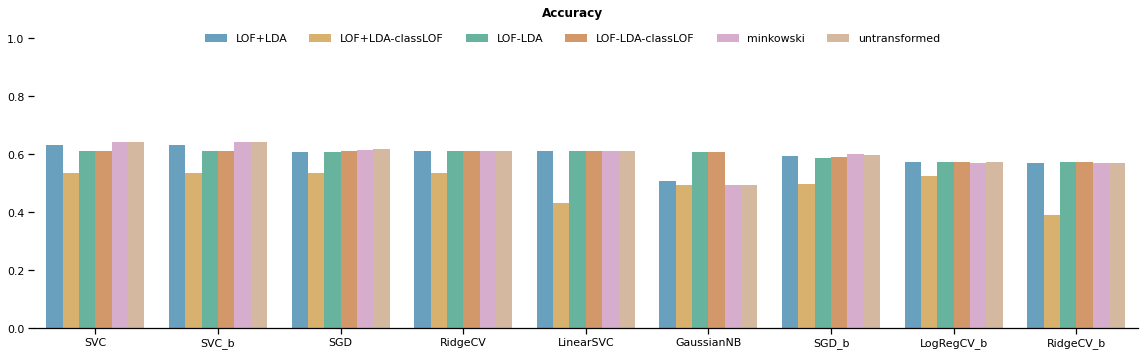

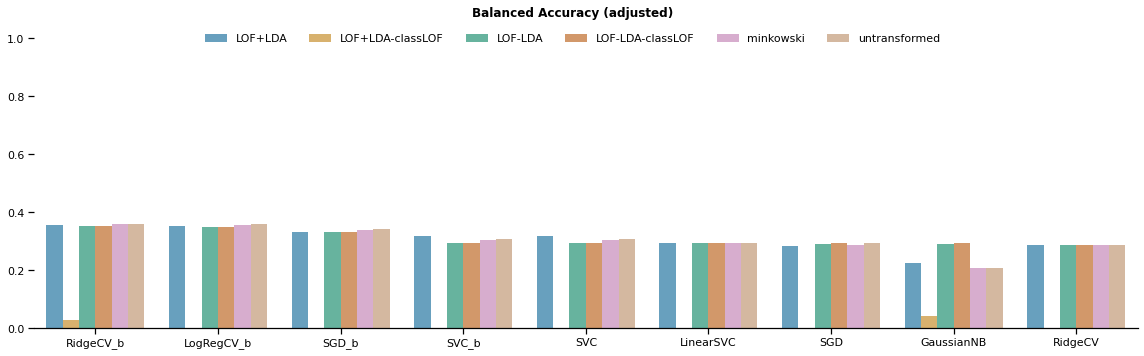

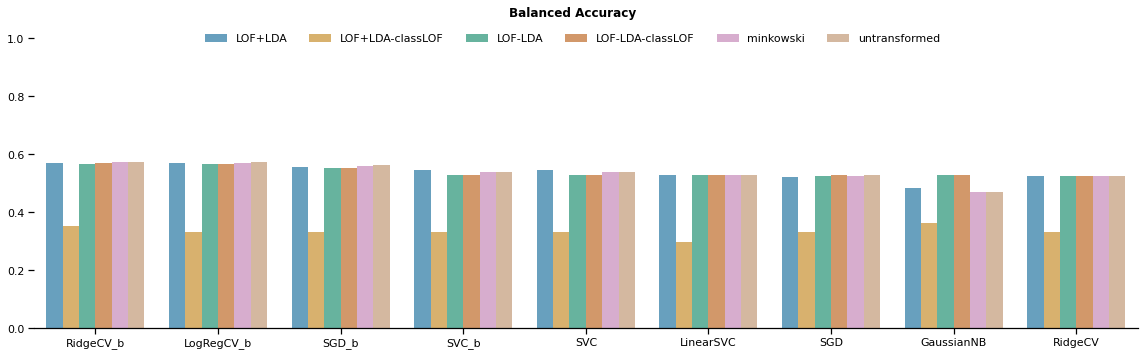

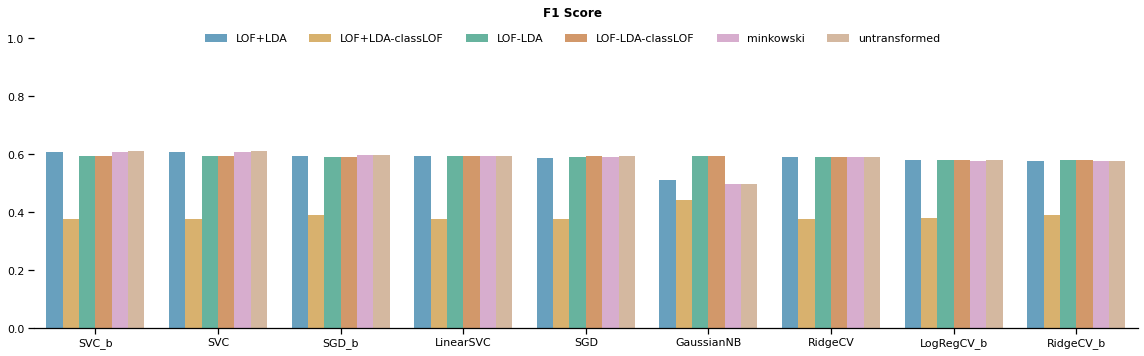

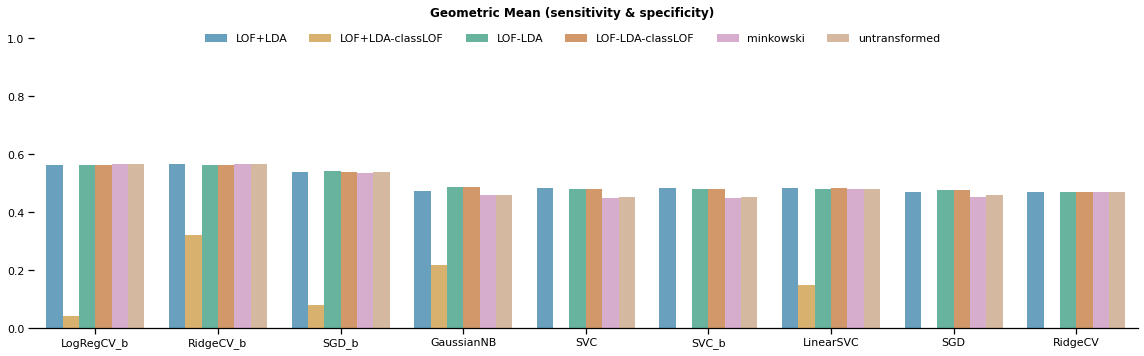

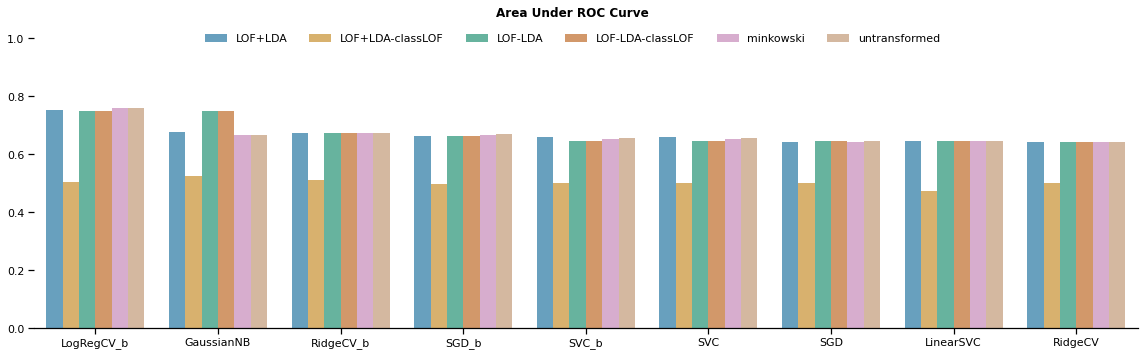

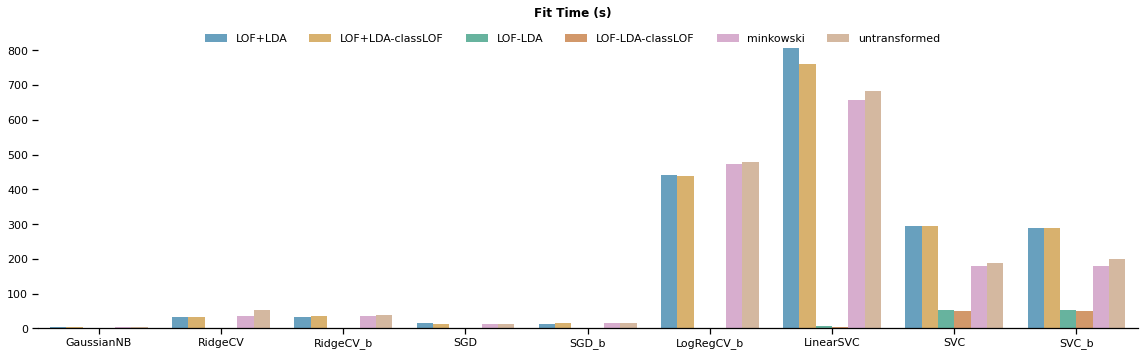

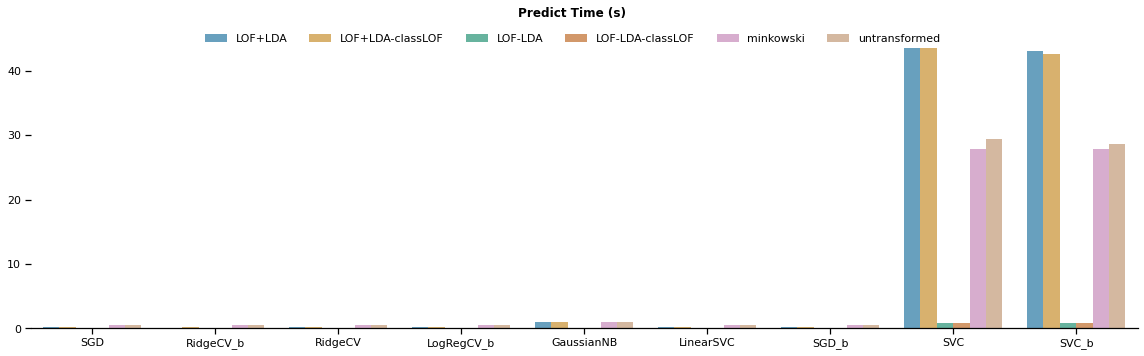

time: 4.65 s


In [16]:
for metric in tqdm(METRICS):
    plot_metric(metric, results_df)

# Discussion

Looks like a bug in the data pipeline. We will fix that before comparing results.

In [17]:
print(f"Time elapsed since notebook_begin_time: {time() - notebook_begin_time} s")
_ = gc_collect()

Time elapsed since notebook_begin_time: 10569.156101465225 s
time: 152 ms


[^top](#Contents)